# 규제가 있는 선형회귀 - 릿지, 라쏘, 엘라스틱넷 회귀

#### 규제가 있는 모델 구축 - 당뇨병 데이터세트
#### 1. 데이터 전처리
#### 2. Ridge, Lasso, Elasticnet regression 구축: 회귀 계수 확인, 하이퍼 파라미터 탐색
#### 3. 교차 검증으로 최적의 하이퍼파라미터 탐색: LassoCV()

In [88]:
# 관련 라이브러리 및 모듈 Import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0. 데이터 수집, 탐색, 준비

In [34]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

####  데이터셋에 대한 설명 및 정보 확인

In [35]:
# 데이터셋 정보확인

In [36]:
diab = load_diabetes()
diab.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [37]:
diab.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

#### 데이터프레임 변환

In [38]:
# 독립변수(피처)와 종속변수를 DataFrame자료형으로 변환

In [39]:
# 데이터셋 객체의 data 배열, 즉, 독립변수 X가되는 피처(특성)들을 DataFrame자료형으로 변환하여
# diab_df생성
# diab_df.head() 데이터 5개 확인

diab_df = pd.DataFrame(data=diab.data, columns= diab.feature_names)
diab_df.head()
diab_df.info() #결측치 하나도 없군! < 결측치가 없어야됨!!!!!!! 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [40]:

diab_df.describe() # diab_df의 기초통계량
pd.options.display.float_format = '{:.5f}' .format # 알기쉬운 소수점 표현으로 표시하기


In [41]:
# 목표 target 붙이기

diab_df['progress'] = diab.target
diab_df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progress
0,0.03808,0.05068,0.06170,0.02187,-0.04422,-0.03482,-0.04340,-0.00259,0.01991,-0.01765,151.00000
1,-0.00188,-0.04464,-0.05147,-0.02633,-0.00845,-0.01916,0.07441,-0.03949,-0.06833,-0.09220,75.00000
2,0.08530,0.05068,0.04445,-0.00567,-0.04560,-0.03419,-0.03236,-0.00259,0.00286,-0.02593,141.00000
3,-0.08906,-0.04464,-0.01160,-0.03666,0.01219,0.02499,-0.03604,0.03431,0.02269,-0.00936,206.00000
4,0.00538,-0.04464,-0.03638,0.02187,0.00393,0.01560,0.00814,-0.00259,-0.03199,-0.04664,135.00000
...,...,...,...,...,...,...,...,...,...,...,...
437,0.04171,0.05068,0.01966,0.05974,-0.00570,-0.00257,-0.02867,-0.00259,0.03119,0.00721,178.00000
438,-0.00551,0.05068,-0.01591,-0.06764,0.04934,0.07917,-0.02867,0.03431,-0.01811,0.04449,104.00000
439,0.04171,0.05068,-0.01591,0.01729,-0.03734,-0.01384,-0.02499,-0.01108,-0.04688,0.01549,132.00000
440,-0.04547,-0.04464,0.03906,0.00122,0.01632,0.01528,-0.02867,0.02656,0.04453,-0.02593,220.00000


In [43]:
# 누락치 확인,  data type 확인 ->  isnull().sum(), target에 결측값이 있으면 해당 관측치 제거

In [44]:
diab_df.isnull().sum()

age         0
sex         0
bmi         0
bp          0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
progress    0
dtype: int64

In [45]:
# X(독립변수), Y(종속변수) 분할
X = diab.data
Y = diab.target

In [59]:
# 학습용, 평가용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# 모델별 계수변화, 알파별 계수 비교 데이터프레임(comp_df)

In [62]:
#각 모델별 계수로 이루어진 데이터프레임 준비
comp_df = pd.DataFrame(index = diab.feature_names + ['R2 score']) 
# 단순히 R2 score 더한거 확인!
comp_df

""
age
sex
bmi
bp
s1
s2
s3
s4
s5
s6


In [48]:
#각 모델별, 규제강도별 평가지표 저장


# 1. 규제가 없는 선형모델

In [63]:
#규제가 없는 다중 선형회귀수행
#모델 구축 및 학습
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

#모델 평가

y_pred = model_LR.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)

# 회귀 계수 확인
LR_coef = pd.Series(model_LR.coef_, index = diab.feature_names)
print(LR_coef)



0.4772897164322618
age     29.25401
sex   -261.70647
bmi    546.29972
bp     388.39834
s1    -901.95967
s2     506.76324
s3     121.15435
s4     288.03527
s5     659.26895
s6      41.37670
dtype: float64


- 계수값 시각화

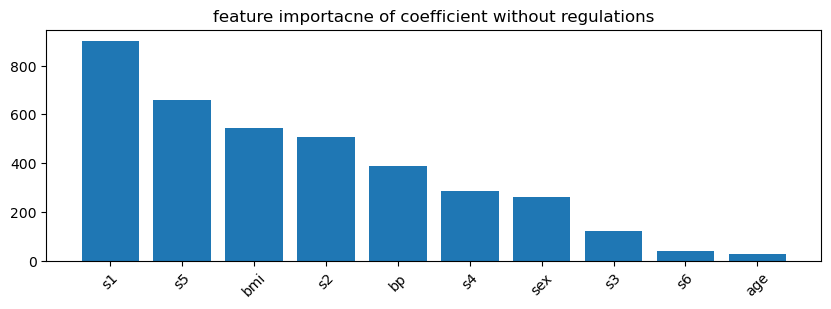

In [64]:


# 시각화
# LR_coef.sort_values(ascending=False)

# 절댓값으로 가장 많이 끼치는 계수 정렬
coef = np.abs(LR_coef).sort_values(ascending=False)

plt.figure(figsize = (10, 3))
plt.title('feature importacne of coefficient without regulations')
plt.bar(coef.index, coef.values)
plt.xticks(rotation = 45)
plt.show()




In [65]:
# 모델별 비교 데이터프레임 열 추가
comp_df['LR'] = np.append(model_LR.coef_, r2)
comp_df


,LR
age,29.25401
sex,-261.70647
bmi,546.29972
bp,388.39834
s1,-901.95967
s2,506.76324
s3,121.15435
s4,288.03527
s5,659.26895
s6,41.37670


# 1. 릿지 모델

In [66]:
model_Ridge = Ridge(alpha=1)
model_Ridge.fit(X_train, y_train)

Ridge(alpha=1)

In [67]:
# 회귀 계수 생성함수

def make_coef_series(model):
    return pd.Series(model.coef_, index = diab.feature_names)

In [68]:
# 릿지 선형회귀 모델 평가: model_Ridge1, alpha=1
y_pred = model_Ridge.predict(X_test)
r2 = r2_score(y_test, y_pred)

# a=1일때 회귀 계수 확인
Ridge_coef = make_coef_series(model_Ridge)
Ridge_coef

age     45.05421
sex    -71.94740
bmi    280.71625
bp     195.21266
s1      -2.22930
s2     -17.54080
s3    -148.68886
s4     120.46724
s5     198.61440
s6     106.93469
dtype: float64

In [ ]:
# 선형 모델 평가


#a = 1 릿지 모델 회귀 계수


- 계수값 시각화

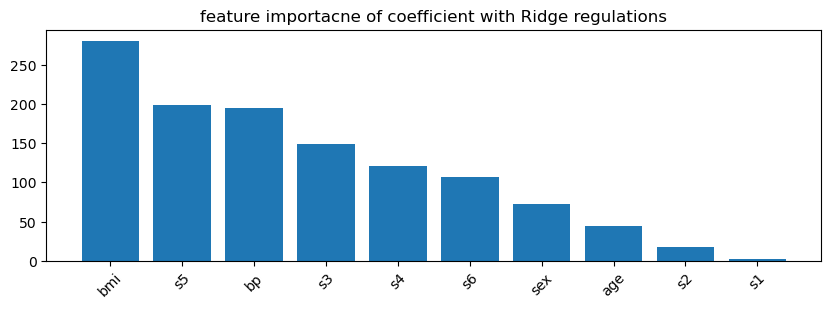

In [69]:
# 시각화


# 절댓값으로 가장 많이 끼치는 계수 정렬
coef = np.abs(Ridge_coef).sort_values(ascending=False)
plt.figure(figsize = (10, 3))
plt.title('feature importacne of coefficient with Ridge regulations')
plt.bar(coef.index, coef.values)
plt.xticks(rotation = 45)
plt.show()


In [70]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list = [0.01, 1, 10, 100]

for alpha in alpha_list :
    model_Ridge = Ridge(alpha = alpha)
    model_Ridge.fit(X_train, y_train)
    y_pred = model_Ridge.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    col_name = f'Ridge:alpha={alpha}'
    comp_df[col_name] = np.append(model_Ridge.coef_, r2)


In [71]:
comp_df

,LR,Ridge:alpha=0.01,Ridge:alpha=1,Ridge:alpha=10,Ridge:alpha=100
age,29.25401,34.16733,45.05421,16.23089,2.07285
sex,-261.70647,-254.04332,-71.94740,-2.96137,-0.00381
bmi,546.29972,550.84488,280.71625,59.52416,6.89991
bp,388.39834,379.12671,195.21266,43.42130,5.08510
s1,-901.95967,-404.25326,-2.22930,13.87507,2.06966
s2,506.76324,123.02922,-17.54080,10.86527,1.74375
s3,121.15435,-99.04167,-148.68886,-37.49585,-4.50888
s4,288.03527,215.03262,120.46724,38.72854,4.90242
s5,659.26895,463.84263,198.61440,49.22475,5.92650
s6,41.37670,50.35149,106.93469,34.73799,4.32870


# 2. 라쏘 모델

In [72]:


# alpha = 1
model_Lasso1 = Lasso(alpha=1)
model_Lasso1.fit(X_train, y_train)


Lasso(alpha=1)

In [74]:
# 라쏘 선형회귀 모델 평가(alpha=1)
y_pred = model_Lasso1.predict(X_test)
r2 = r2_score(y_test, y_pred)

# 선형 모델 평가


#a = 1 라쏘 모델 회귀 계수
lasso_coef = make_coef_series(model_Lasso1)



- 계수 시각화

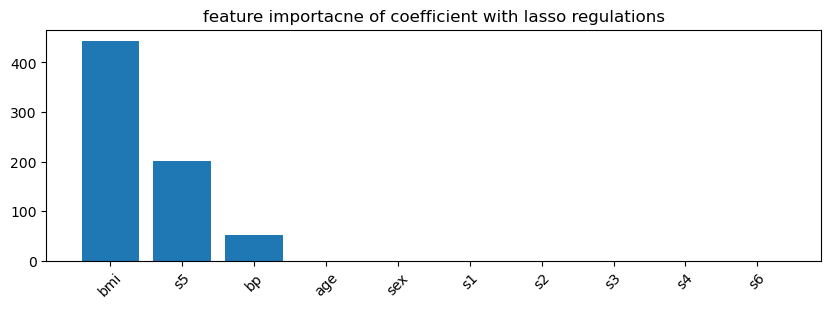

In [76]:

# 시각화
coef = np.abs(lasso_coef).sort_values(ascending=False)
plt.figure(figsize = (10, 3))
plt.title('feature importacne of coefficient with lasso regulations')
plt.bar(coef.index, coef.values)
plt.xticks(rotation = 45)
plt.show()


In [77]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list = [0.01, 1, 10, 100]

for alpha in alpha_list :
    model_Lasso1 = Lasso(alpha = alpha)
    model_Lasso1.fit(X_train, y_train)
    y_pred = model_Lasso1.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    col_name = f'Lasso:alpha={alpha}'
    comp_df[col_name] = np.append(model_Lasso1.coef_, r2)

In [78]:
comp_df

,LR,Ridge:alpha=0.01,Ridge:alpha=1,Ridge:alpha=10,Ridge:alpha=100,Lasso:alpha=0.01,Lasso:alpha=1,Lasso:alpha=10,Lasso:alpha=100
age,29.25401,34.16733,45.05421,16.23089,2.07285,28.24636,0.00000,0.00000,0.00000
sex,-261.70647,-254.04332,-71.94740,-2.96137,-0.00381,-250.81918,-0.00000,0.00000,0.00000
bmi,546.29972,550.84488,280.71625,59.52416,6.89991,556.21587,443.70339,0.00000,0.00000
bp,388.39834,379.12671,195.21266,43.42130,5.08510,380.65950,51.60109,0.00000,0.00000
s1,-901.95967,-404.25326,-2.22930,13.87507,2.06966,-468.73954,0.00000,0.00000,0.00000
s2,506.76324,123.02922,-17.54080,10.86527,1.74375,166.99342,0.00000,0.00000,0.00000
s3,121.15435,-99.04167,-148.68886,-37.49585,-4.50888,-60.21946,-0.00000,-0.00000,-0.00000
s4,288.03527,215.03262,120.46724,38.72854,4.90242,230.91625,0.00000,0.00000,0.00000
s5,659.26895,463.84263,198.61440,49.22475,5.92650,492.63436,201.96648,0.00000,0.00000
s6,41.37670,50.35149,106.93469,34.73799,4.32870,43.96935,0.00000,0.00000,0.00000


# 3. 엘라스틱넷 모델

In [79]:


# 모델 구축 및 학습(alpha=1, l1_ratio=0.5)
from sklearn.linear_model import ElasticNet

model_ElasticNet1 = ElasticNet(alpha=1, l1_ratio=0.5)
model_ElasticNet1.fit(X_train, y_train)


ElasticNet(alpha=1)

In [86]:
#모델 평가 및 회귀 계수 확인
# 엘라스틱넷 선형회귀 모델 평가(alpha=1, L1_ratio=0.5)
# 선형 모델 평가

y_pred = model_ElasticNet1.predict(X_test)
r2 = r2_score(y_test, y_pred)
#a = 1 엘라스틱넷 모델 회귀 계수
ElasticNet1_coef = pd.Series(model_ElasticNet1.coef_, index = diab.feature_names)

print(r2)
print(ElasticNet1_coef)

0.0031070233135319647
age    0.36757
sex    0.00000
bmi    3.51205
bp     2.32865
s1     0.38019
s2     0.16834
s3    -1.95596
s4     2.22813
s5     2.88743
s6     1.84622
dtype: float64


- 계수 시각화

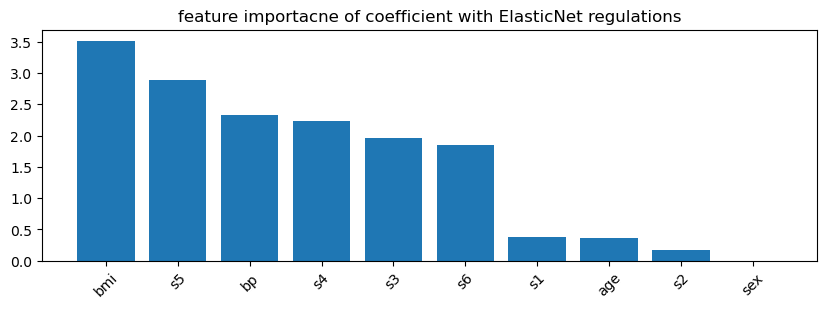

In [87]:


# 시각화


# 절댓값으로 가장 많이 끼치는 계수 정렬
coef = np.abs(ElasticNet1_coef).sort_values(ascending=False)
plt.figure(figsize = (10, 3))
plt.title('feature importacne of coefficient with ElasticNet regulations')
plt.bar(coef.index, coef.values)
plt.xticks(rotation = 45)
plt.show()


In [89]:
# alpha_list=[0.01, 1, 10, 100]인 경우, l1_ratio=0.5 

alpha_list = [0.01, 1, 10, 100]

for alpha in alpha_list:
    model_ElasticNet = ElasticNet(alpha = alpha, l1_ratio=0.5)
    model_ElasticNet.fit(X_train, y_train)
    y_pred = model_ElasticNet.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    col_name = 'ElasticNet(alpha={:.2f}, l1_ratio=0.5' .format(alpha)
    comp_df[col_name] = np.append(model_ElasticNet.coef_, r2)


In [90]:
comp_df

,LR,Ridge:alpha=0.01,Ridge:alpha=1,Ridge:alpha=10,Ridge:alpha=100,Lasso:alpha=0.01,Lasso:alpha=1,Lasso:alpha=10,Lasso:alpha=100,"ElasticNet(alpha=0.01, l1_ratio=0.5","ElasticNet(alpha=1.00, l1_ratio=0.5","ElasticNet(alpha=10.00, l1_ratio=0.5","ElasticNet(alpha=100.00, l1_ratio=0.5"
age,29.25401,34.16733,45.05421,16.23089,2.07285,28.24636,0.00000,0.00000,0.00000,41.41800,0.36757,0.00000,0.00000
sex,-261.70647,-254.04332,-71.94740,-2.96137,-0.00381,-250.81918,-0.00000,0.00000,0.00000,-45.93502,0.00000,0.00000,0.00000
bmi,546.29972,550.84488,280.71625,59.52416,6.89991,556.21587,443.70339,0.00000,0.00000,225.05346,3.51205,0.00000,0.00000
bp,388.39834,379.12671,195.21266,43.42130,5.08510,380.65950,51.60109,0.00000,0.00000,158.16323,2.32865,0.00000,0.00000
s1,-901.95967,-404.25326,-2.22930,13.87507,2.06966,-468.73954,0.00000,0.00000,0.00000,9.02107,0.38019,0.00000,0.00000
s2,506.76324,123.02922,-17.54080,10.86527,1.74375,166.99342,0.00000,0.00000,0.00000,-1.76203,0.16834,0.00000,0.00000
s3,121.15435,-99.04167,-148.68886,-37.49585,-4.50888,-60.21946,-0.00000,-0.00000,-0.00000,-124.24002,-1.95596,-0.00000,-0.00000
s4,288.03527,215.03262,120.46724,38.72854,4.90242,230.91625,0.00000,0.00000,0.00000,106.91012,2.22813,0.00000,0.00000
s5,659.26895,463.84263,198.61440,49.22475,5.92650,492.63436,201.96648,0.00000,0.00000,165.00609,2.88743,0.00000,0.00000
s6,41.37670,50.35149,106.93469,34.73799,4.32870,43.96935,0.00000,0.00000,0.00000,97.21348,1.84622,0.00000,0.00000
